# CURENT WECC Verification

Prepared by [Hantao Cui](https://cui.eecps.com). Last revised 23 May 2020. 

## Background 

The [CURENT](https://curent.utk.edu) WECC system contains 179 buses and 263 branches. Two line trip scenarios are created to verify ANDES simulation results with DSATools TSAT and Siemens PTI PSS/E.

Dynamic data is based on the CURENT WECC 179-Bus test system, which uses models GENROU, TGOV1, IEEEG1, EXST2, EXDC2, ESST3A, IEEEST, ST2CUT and ESDC2A, the saturation of which could be implemented differently across software. 

### Simulation Parameters

Integretion method: Trapezidal Rule (ANDES and TSAT), the default second order Adams-Bashforth method (AB-2) (PSS/E)

Time step size: `1/120` sec. (Note: step size between `1/30` to `1/120` has little impact on the ANDES results. One can use `tstep=1/30` to obtain almost the same results.)

Load conversion: static loads are converted to 100% constant impedances for both P and Q. 

TSAT automatic parameter correction is disabled.

### Initialization

Power flow solutions are identical across all the three software.

GENROU initialization ($E_{FD}$, $E_{TERM}$, $P$, $Q$, $\delta$, $I_d$ and $I_q$) is identical to that from **PSS/E** for all cases (with and without generator saturation). Note that $I_d$ and $I_q$ are in machine base in PSS/E but in system base in ANDES.  

GENROU initialization (including all the internal variables $E'_d$, $E'_q$, $\psi_{kd}$, $\psi_{kq}$, $\psi''_d$, and $\psi''_q$) is identical to that from [**OpenIPSL**](https://github.com/openipsl/openipsl).

No controller limit violation occurs during initialization.

### Conclusion

The finding is that, **for particular disturbances in large systems, neither two of ANDES, TSAT and PSS/E could match**. Implementation details in commercial software are lacking. Thus, it could be futile to insist on obtaining the same results for large systems, especially with several complex models.

Nevertheless, Scenario 2 shows that ANDES results are trustworthy. **In fact, ANDES is open-source with all the implemented equations clearly documented, which makes the results highly credible for research and education purposes.**

In [1]:
import andes
import numpy as np
from andes.utils.tsat import tsat_to_df, psse_to_df, plot_comparison, run_cmp

andes.config_logger(stream_level=30)

## Scenario 1

Line 38-39 trips and reconnects after 0.1 sec. This branch is a transformer branch that connects generator #11 on Bus 39 to Bus 38. It is the only link to Bus 39.

In [2]:
ss = run_cmp('wecc.raw', dyr='wecc.dyr', fault_line='Line_221',
             t1=1.0, t2=1.1, tstep=1/120)

<Toggle Toggle_1>: Line.Line_221 status changed to 0.0 at t=1.0 sec.
<Toggle Toggle_2>: Line.Line_221 status changed to 1.0 at t=1.1 sec.
100%|████████████████████████████████| 100/100 [00:16<00:00,  5.89%/s]


In [3]:
# Line_221 information
ss.Line.cache.df_in.iloc[220]

idx       Line_221
u                1
name      Line_221
bus1            38
bus2            39
Sn             100
fn              60
Vn1            230
Vn2             18
r           0.0005
x           0.0238
b                0
g                0
b1               0
g1               0
b2               0
g2               0
trans            1
tap              1
phi              0
owner         None
xcoord        None
ycoord        None
Name: 220, dtype: object

In [4]:
# Load TSAT and PSSE Outputs
omega2 = tsat_to_df('omega2.xls')
v2 = tsat_to_df('v2.xls')

omega2_psse = psse_to_df('omega2_psse.xlsx')
v2_psse = psse_to_df('v2_psse.xlsx')
omega2_psse.iloc[:, 1:] += 1
omega2_psse.iloc[:, 1:] *= 60

# prepare variable headers for TSAT and PSSE
def header_replace(fname, idx, offset, old_str, new_str):
    """
    Utility function for replacing strings in variable header
    """
    old_headers = [fname[i + offset] for i in idx]
    return [i.replace(old_str, new_str) for i in old_headers]

fname = ss.TDS.plt._fname
tsat_omega_headers = header_replace(fname, ss.GENROU.omega.a, 1, "GENROU", "TSAT")
tsat_v_headers = header_replace(fname, ss.GENROU.v.a, 1 + ss.dae.n, "Bus", "TSAT")

psse_omega_headers = header_replace(fname, ss.GENROU.omega.a, 1, "GENROU", "PSSE")
psse_v_headers = header_replace(fname, ss.GENROU.v.a, 1 + ss.dae.n, "Bus", "PSSE")

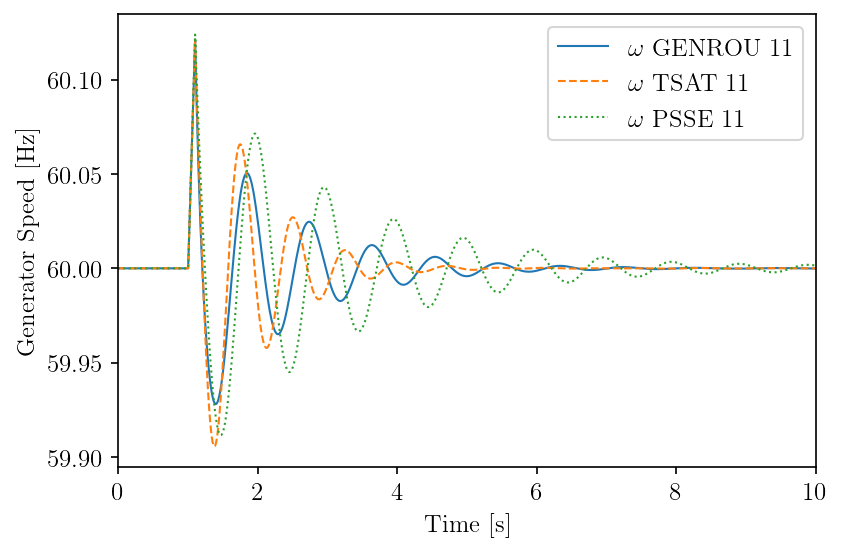

In [5]:
fig, ax = plot_comparison(ss, ss.GENROU.omega, omega2,
                          a=(10,), a_tsat=[10], a_psse=[10],
                          ylabel="Generator Speed [Hz]",
                          tsat_header=tsat_omega_headers,
                          psse_data = omega2_psse,
                          psse_header = psse_omega_headers,
                          scale=60, right=10,
                          legend=True,
                          show=False,
                         )

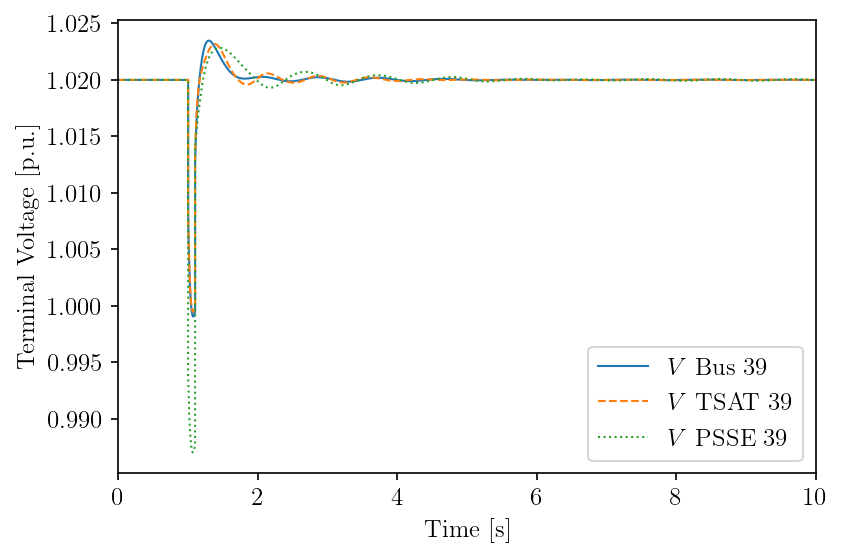

In [6]:
fig, ax = plot_comparison(ss, ss.GENROU.v, v2,
                          a=(10,), a_tsat=[10], a_psse=[10],
                          ylabel="Terminal Voltage [p.u.]",
                          tsat_header=tsat_v_headers,
                          psse_data = v2_psse,
                          psse_header = psse_v_headers,
                          scale=1, right=10,
                          legend=True,
                          show=False
                         )

## Scenario 2

In this scenario, Line 4-16 trips and reconnects after 0.1 sec. This line in the eastern zone that connects two generator buses (CRAIG and SAN JUAN).

In [7]:
ss2 = run_cmp('wecc.raw', dyr='wecc.dyr', fault_line='Line_2',
              t1=1.0, t2=1.1, tstep=1/120)

<Toggle Toggle_1>: Line.Line_2 status changed to 0.0 at t=1.0 sec.  
<Toggle Toggle_2>: Line.Line_2 status changed to 1.0 at t=1.1 sec.  
100%|████████████████████████████████| 100/100 [00:18<00:00,  5.45%/s]


In [8]:
# Line 2 information
ss2.Line.cache.df_in.iloc[1]

idx        Line_2
u               1
name       Line_2
bus1            4
bus2           16
Sn            100
fn             60
Vn1           345
Vn2           345
r         0.00977
x            0.11
b               2
g               0
b1              0
g1              0
b2              0
g2              0
trans           0
tap             1
phi             0
owner        None
xcoord       None
ycoord       None
Name: 1, dtype: object

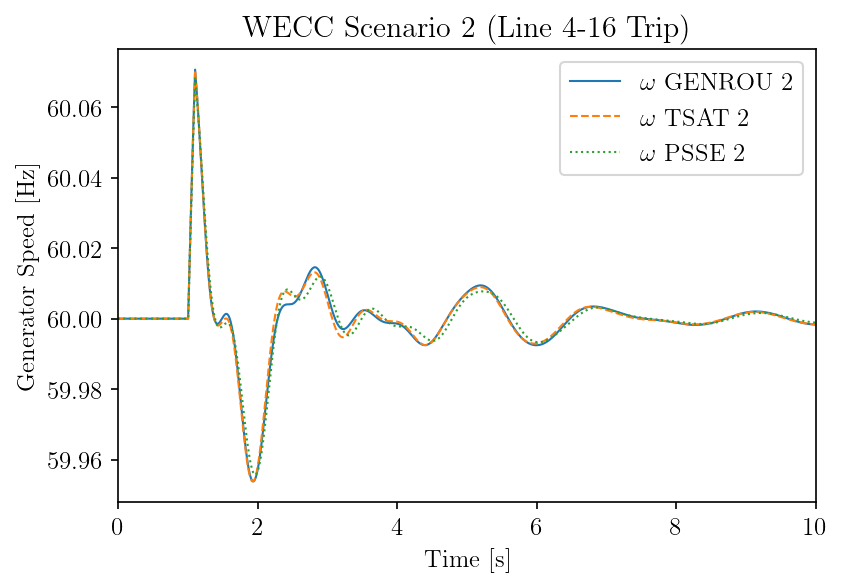

In [9]:
# load data
omega = tsat_to_df('omega.xls')
v = tsat_to_df('v.xls')

omega_psse = psse_to_df('omega_psse.xlsx')
v_psse = psse_to_df('v_psse.xlsx')
omega_psse.iloc[:, 1:] += 1
omega_psse.iloc[:, 1:] *= 60

fig, ax = plot_comparison(ss2, ss2.GENROU.omega, omega,
                          a=(1,), a_tsat=[1], a_psse=[1],
                          ylabel="Generator Speed [Hz]",
                          title="WECC Scenario 2 (Line 4-16 Trip)",
                          tsat_header=tsat_omega_headers,
                          psse_data = omega_psse,
                          psse_header = psse_omega_headers,
                          scale=60, right=10,
                          legend=True,
                          show=False
                         )

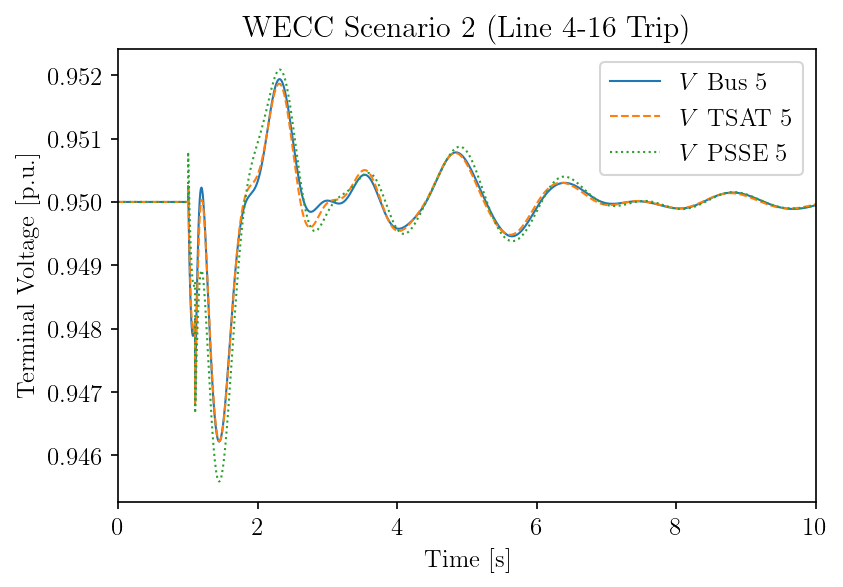

In [10]:
fig, ax = plot_comparison(ss2, ss2.GENROU.v, v,
                          a=(1,), a_tsat=[1], a_psse=[1],
                          ylabel="Terminal Voltage [p.u.]",
                          title="WECC Scenario 2 (Line 4-16 Trip)",
                          tsat_header=tsat_v_headers,
                          psse_data = v_psse,
                          psse_header = psse_v_headers,
                          scale=1, right=10,
                          legend=True,
                          show=False
                         )

## Appendix: CURENT WECC 179-Bus System Data

### Power Flow Data (PSS/E RAW format)

In [11]:
data = !cat wecc.raw
print('\n'.join(data))

0,   100.00,  32, 0, 1, 60.00     / PSS(R)E 32 RAW created by rawd32  THU, MAY 21 2020  10:24
WESTERN ELECTRICITY COORDINATING COUNCIL 179-BUS SYSTEM (MOD
DISTRIBUTED WITH ANDES (HTTPS://GITHUB.COM/CUIHANTAO/ANDES)
     1,'CORONADO    ', 500.0000,1,   1,   1,   1,0.97947, -26.1745
     2,'CHOLLA      ', 345.0000,1,   1,   1,   1,0.97744, -16.9603
     3,'CORONADO    ',  20.0000,2,   1,   1,   1,1.04000, -19.6589
     4,'CRAIG       ', 345.0000,1,   1,   1,   1,0.97518,  16.2755
     5,'CRAIG       ',  22.0000,2,   1,   1,   1,0.95000,  23.5536
     6,'FOURCORN    ', 500.0000,1,   1,   1,   1,1.06814,  -7.9038
     7,'FOURCORN    ', 345.0000,1,   1,   1,   1,1.00914,  -4.6874
     8,'FCNGN4CC    ',  22.0000,2,   1,   1,   1,1.00000,   2.2301
     9,'FOURCORN    ', 230.0000,1,   1,   1,   1,1.00726,  -5.2308
    10,'HAYDEN      ',  20.0000,2,   1,   1,   1,1.00000,  33.7299
    11,'NAVAJO      ', 500.0000,1,   2,   1,   1,1.07205, -23.9351
    12,'NAVAJO 2    ',  26.0000,2,   2,   1,   1

### Dynamic Data (PSS/E DYR format)

In [12]:
data = !cat wecc.dyr
print('\n'.join(data))

      3 'GENROU' 1     3.9000      0.32000E-01  0.54000      0.62000E-01
          2.6400       5.0000       1.8600       1.7800      0.25000
         0.45300      0.19500      0.14500       1.9714       6.9000      /
      3 'IEEEST' 1          3            0       0.0000       0.0000
          0.0000       0.0000       0.0000       0.0000       0.0000
          0.0000       0.0000      0.75000       1.0000       4.2000
         -2.0000      0.10000     -0.10000       0.0000       0.0000      /
      3 'ESST3A' 1    0.20000E-01  0.30000     -0.20000       8.0000
          1.0000       5.0000       20.000       0.0000       99.000
         -99.000       1.0000       3.6700      0.43500       6.4800
         0.10000E-01  0.98000E-02   4.8600       3.3300      0.40000
          99.000       0.0000    /
      3 'IEEEG1' 1          0           0        20.000      0.10000
          0.0000      0.20000       1.0000      -1.0000      0.95000
          0.0000      0.10000       0.0000       0